In [21]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

class TowersOfHanoi:
    def __init__(self, state):
        self.state = state              # "State" is a tuple of length N, where N is the number of discs, and the elements are peg indices in [0,1,2]
        self.discs = len(self.state)

    def discs_on_peg(self, peg):
        return [disc for disc in range(self.discs) if self.state[disc] == peg]

    def move_allowed(self, move):
        discs_from = self.discs_on_peg(move[0])
        discs_to = self.discs_on_peg(move[1])
        if discs_from:
            return (min(discs_to) > min(discs_from)) if discs_to else True
        else:
            return False

    def get_moved_state(self, move):
        if self.move_allowed(move):
            disc_to_move = min(self.discs_on_peg(move[0]))
        moved_state = list(self.state)
        moved_state[disc_to_move] = move[1]
        return tuple(moved_state)

# Generates the reward matrix for the Towers of Hanoi game as a Pandas DataFrame
def generate_reward_matrix(N):      # N is the number of discs
    states = list(itertools.product(list(range(3)), repeat=N))
    moves = list(itertools.permutations(list(range(3)), 2))

    print("Tower of Hanoi game ",states)
    print("moces of Tower of Hanoi  ",moves)
    R = pd.DataFrame(index=states, columns=states, data=-np.inf)
    for state in states:
        tower = TowersOfHanoi(state=state)
        for move in moves:
            if tower.move_allowed(move):
                next_state = tower.get_moved_state(move)
                R[state][next_state] = 0
    final_state = tuple([2]*N)          # Define final state as all discs being on the last peg
    R[final_state] += 100               # Add a reward for all moves leading to the final state
    return R.values

def learn_Q(R, gamma=0.8, alpha=1.0, N_episodes=1000):
    Q = np.zeros(R.shape)
    states=list(range(R.shape[0]))
    for n in range(N_episodes):
        Q_previous = Q
        state = np.random.choice(states)                # Randomly select initial state
        next_states = np.where(R[state,:] >= 0)[0]      # Generate a list of possible next states
        next_state = np.random.choice(next_states)      # Randomly select next state from the list of possible next states
        V = np.max(Q[next_state,:])                     # Maximum Q-value of the states accessible from the next state
        Q[state, next_state] = (1-alpha)*Q[state, next_state] + alpha*(R[state, next_state] + gamma*V)      # Update Q-values
    if np.max(Q) > 0:
        Q /= np.max(Q)      # Normalize Q to its maximum value
    return Q

def get_policy(Q, R):
    Q_allowed = pd.DataFrame(Q)[pd.DataFrame(R) >= 0].values
    policy = []
    for i in range(Q_allowed.shape[0]):
        row = Q_allowed[i,:]
        sorted_vals = np.sort(row)
        sorted_vals = sorted_vals[~np.isnan(sorted_vals)][::-1]
        sorted_args = row.argsort()[np.where(~np.isnan(sorted_vals))][::-1]

        max_vals = [val for val in sorted_vals if val==sorted_vals[0]]
        max_args = [sorted_args[i] for i,val in enumerate(sorted_vals) if val==sorted_vals[0]]
        policy.append(max_args)
    return policy

def play(policy):
    start_state = 0
    end_state = len(policy)-1
    state = start_state
    moves = 0
    while state != end_state:
        state = np.random.choice(policy[state])
        moves += 1
    return moves

def play_average(policy, play_times=100):
    moves = np.zeros(play_times)
    
    for n in range(play_times):
        moves[n] = play(policy)
    print("here is finale policy",moves)
    return np.mean(moves), np.std(moves)

def Q_performance(R, episodes, play_times=100):
    means = np.zeros(len(episodes))

    stds = np.zeros(len(episodes))

    for n, N_episodes in enumerate(episodes):
        Q = learn_Q(R, N_episodes = N_episodes)
        policy = get_policy(Q,R)
        means[n], stds[n] = play_average(policy, play_times)
    print(stds)
    return means, stds

def Q_performance_average(R, episodes, learn_times = 100, play_times=100):
    means_times = np.zeros((learn_times, len(episodes)))
    stds_times = np.zeros((learn_times, len(episodes)))
    for n in range(learn_times):
        means_times[n,:], stds_times[n,:] = Q_performance(R, episodes, play_times=play_times)
    means_averaged = np.mean(means_times, axis = 0)
    stds_averaged = np.mean(stds_times, axis = 0)
    return means_averaged, stds_averaged

def plot_results(episodes, means_averaged, stds_averaged, N, block=False):
    fig = plt.figure()
    plt.loglog(episodes, means_averaged,'b.-',label='Average performance')
    plt.loglog(episodes, means_averaged + stds_averaged, 'b', alpha=0.5)
    plt.loglog(episodes, means_averaged - stds_averaged, 'b', alpha=0.5)
    plt.fill_between(episodes, means_averaged-stds_averaged, means_averaged+stds_averaged, facecolor='blue', alpha=0.5)
    optimum_moves = 2**N - 1
    plt.axhline(y=optimum_moves, color='g', label='Optimum (=%s moves)' % optimum_moves)
    plt.xlabel('Number of training episodes')
    plt.ylabel('Number of moves')
    plt.grid('on', which='both')
    plt.title('Q-learning the Towers of Hanoi game with %s discs' % N)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels)
    plt.show(block=block)


In [23]:
N = 3                                   # Number of discs in the Towers of Hanoi game
R = generate_reward_matrix(N)
episodes = [0, 1, 10, 30, 100, 300, 600, 1000, 3000, 6000]
play_times=100
means = np.zeros(len(episodes))
stds = np.zeros(len(episodes))
for n, N_episodes in enumerate(episodes):
    Q = learn_Q(R, N_episodes = N_episodes)
    policy = get_policy(Q,R)
    
    means[n], stds[n] = play_average(policy, play_times)
print(policy)
print(stds)
    



Tower of Hanoi game  [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
moces of Tower of Hanoi   [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
here is finale policy [ 96.  97. 190.  86.  61.  62. 127.  36. 338.  41.  31.  78. 252. 138.
 201.  13. 234. 155. 376. 114. 112.  22.  79.  93. 159. 296.  15. 208.
 242.  17. 129.  66.  84.  23.  39.  16.  37. 127.  74.  49.  37.  51.
 138. 120.  27. 151.  54.  89. 109.  59.  28. 101. 288.  53. 617.  67.
  54.  61.  29. 133.  94.  84.  80. 523. 121.  89.  65.  67. 454.  55.
  92.  37. 163. 125. 182.  77. 129. 142. 583.  22.  41.  44. 129. 130.
 155. 139. 128. 181. 192. 246.  47.  28. 204. 274.  18.  33.  79. 160.
  46.  71.]
here is finale policy [ 65. 189. 439. 100.  39.  87. 265. 389.  49.  57. 30

Tower of Hanoi game  [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
moces of Tower of Hanoi   [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
here is finale policy [ 38. 245.  39. 252.  45. 384. 409. 145.  61.  67.]
here is finale policy [ 32. 265.  15. 212. 246.  23.  68.  18. 160. 192.]
here is finale policy [244. 154. 142.  22. 244. 570.  25.  46. 407.  29.]
here is finale policy [ 33. 105.  53. 103. 159.  19.  78. 107.  39.  38.]
here is finale policy [ 24. 111.  54.  36.  43.  58.   8.  47.  28.  19.]
here is finale policy [10. 11. 11.  8. 16. 15. 12.  8. 17. 18.]
here is finale policy [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
here is finale policy [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
here is finale policy [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
here is fi

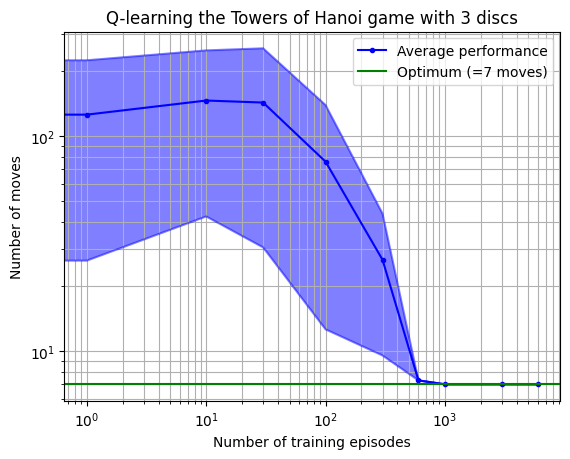

In [24]:
N = 3                                   # Number of discs in the Towers of Hanoi game
R = generate_reward_matrix(N)
episodes = [0, 1, 10, 30, 100, 300, 600, 1000, 3000, 6000]
means_averaged, stds_averaged = Q_performance_average(R, episodes, learn_times=10, play_times=10)
plot_results(episodes, means_averaged, stds_averaged, N)